In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

# Load files
log_df = pd.read_csv('../data/udk_moodle_log_course_670.csv', parse_dates=['timecreated'])
grades_df = pd.read_csv('../data/udk_moodle_grades_course_670.csv')

# Tính features từ logs
user_actions = log_df.groupby('userid').size().to_frame('actions')

# Merge với grades (avg finalgrade nếu multi per user)
avg_grades = grades_df.groupby('userid')['finalgrade'].mean().to_frame('finalgrade')
features_df = pd.merge(user_actions, avg_grades, left_index=True, right_index=True, how='inner')
features_df = features_df.fillna({'finalgrade': features_df['finalgrade'].mean()})  # Fill nếu null

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(features_df[['actions', 'finalgrade']])

print("Features shape:", features_df.shape)
print(features_df.head())
print("Corr check:", features_df['actions'].corr(features_df['finalgrade']))

Features shape: (20, 2)
        actions  finalgrade
userid                     
7267         60   -1.000000
8609        948    9.294118
8670       1245    9.000000
8860        253    5.529412
8964        487    4.666667
Corr check: 0.7542346154548039


d:\Install\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


Silhouette gốc: 0.550 (thấp nếu lộn xộn)


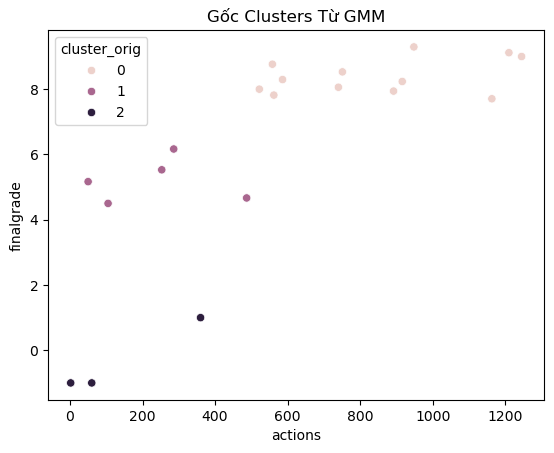

In [2]:
# Fit GMM
gmm = GaussianMixture(n_components=3, random_state=42)
gmm.fit(X_scaled)

# Predict labels gốc (soft/hard assignment)
labels_orig = gmm.predict(X_scaled)
sil_orig = silhouette_score(X_scaled, labels_orig)
print(f"Silhouette gốc: {sil_orig:.3f} (thấp nếu lộn xộn)")

# Plot clusters gốc
features_df['cluster_orig'] = labels_orig
sns.scatterplot(data=features_df, x='actions', y='finalgrade', hue='cluster_orig')
plt.title('Gốc Clusters Từ GMM')
plt.show()

Silhouette synthetic: 0.574 (>0.4: rõ ràng)
Phân bố nhóm: group
giỏi    123
khá      46
yếu      31
Name: count, dtype: int64
Corr synthetic: 0.7333056523556025


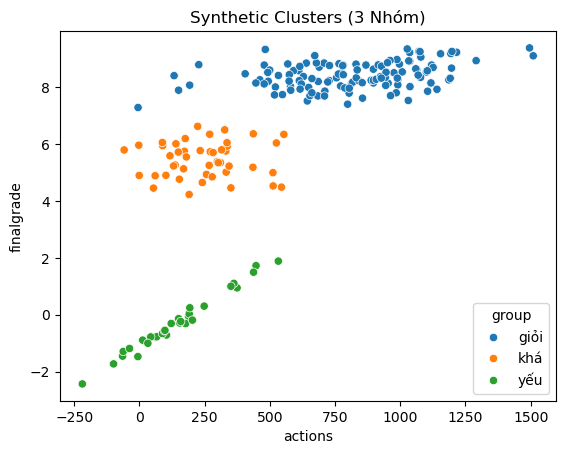

In [3]:
# Generate synthetic
n_synth = len(features_df) * 10
X_synth_scaled, _ = gmm.sample(n_synth)
probs = gmm.predict_proba(X_synth_scaled)
X_synth = scaler.inverse_transform(X_synth_scaled)

synth_df = pd.DataFrame(X_synth, columns=['actions', 'finalgrade'])
synth_df['userid'] = range(10000, 10000 + n_synth)
synth_df['cluster'] = np.argmax(probs, axis=1)

cluster_means = synth_df.groupby('cluster')[['actions', 'finalgrade']].mean()
sorted_clusters = cluster_means.mean(axis=1).sort_values(ascending=False).index
cluster_names = {sorted_clusters[0]: 'giỏi', sorted_clusters[1]: 'khá', sorted_clusters[2]: 'yếu'}
synth_df['group'] = synth_df['cluster'].map(cluster_names)

# Validate clusters
labels_synth = synth_df['cluster'].values
sil_synth = silhouette_score(X_synth_scaled, labels_synth)
print(f"Silhouette synthetic: {sil_synth:.3f} (>0.4: rõ ràng)")
print("Phân bố nhóm:", synth_df['group'].value_counts())
print("Corr synthetic:", synth_df['actions'].corr(synth_df['finalgrade']))

# Plot
sns.scatterplot(data=synth_df, x='actions', y='finalgrade', hue='group')
plt.title('Synthetic Clusters (3 Nhóm)')
plt.show()

In [4]:
from scipy.stats import nbinom  # Negative Binomial

# Fit NB cho actions (r, p từ mean/var gốc)
mean_orig = user_actions.mean()  # 636.14
var_orig = user_actions.var()    # 293456
r_nb = mean_orig**2 / (var_orig - mean_orig)  # ~0.14 (low r = over-disp)
p_nb = r_nb / (r_nb + mean_orig)
print(f"NB params: r={float(r_nb):.2f}, p={float(p_nb):.4f}")

# Probs gốc từ phân tích trước (hardcode từ output)
probs_action = {'viewed': 0.801, 'updated': 0.068, 'graded': 0.038, 'uploaded': 0.028, 'created': 0.028, 'submitted': 0.018}  # Normalize nếu cần
probs_hour = {11: 0.096, 12: 0.093, 13: 0.083, 16: 0.069, 15: 0.068}  # Top, fill rest uniform
probs_hour = {h: probs_hour.get(h, 1/len(range(24))) for h in range(24)}  # Normalize
total = sum(probs_hour.values())
probs_hour = {h: v / total for h, v in probs_hour.items()}

# Generate logs
synthetic_logs = []
start_date = pd.Timestamp('2022-09-01')
for _, row in synth_df.iterrows():
    num_actions = max(1, int(nbinom.rvs(r_nb, p_nb)))  # NB sample, min 1
    group = row['group']
    
    # Bias probs theo group
    if group == 'giỏi':
        probs_action_bias = probs_action.copy()
        probs_action_bias['updated'] += 0.20  # Tăng active
        probs_action_bias['viewed'] -= 0.10
    elif group == 'yếu':
        probs_action_bias = probs_action.copy()
        probs_action_bias['viewed'] += 0.10
        probs_action_bias['updated'] -= 0.05
    else:  # khá
        probs_action_bias = probs_action.copy()
    
    # Normalize bias probs
    total_bias = sum(probs_action_bias.values())
    probs_action_bias = {k: v/total_bias for k, v in probs_action_bias.items()}
    
    for _ in range(num_actions):
        action = np.random.choice(list(probs_action_bias.keys()), p=list(probs_action_bias.values()))
        eventname = '\\mod_assign\\event\\course_module_viewed' if action == 'viewed' else '\\mod_quiz\\event\\attempt_started'  # Map đơn giản
        hour = np.random.choice(list(probs_hour.keys()), p=list(probs_hour.values()))
        timecreated = start_date + pd.Timedelta(days=np.random.randint(365), hours=hour, minutes=np.random.randint(60))
        userid = row['userid']
        courseid = 670
        other = "{'assignid': '****'}" if np.random.rand() > 0.5 else np.nan
        
        synthetic_logs.append({
            'id': np.random.randint(9000000, 10000000),  # Fake ID
            'timecreated': timecreated,
            'eventname': eventname,
            'action': action,
            'target': 'course_module',
            'userid': userid,
            'courseid': courseid,
            'other': other
        })

synth_logs_df = pd.DataFrame(synthetic_logs)
print("Synthetic logs shape:", synth_logs_df.shape)
synth_logs_df.to_csv('synthetic_logs.csv', index=False)

C:\Users\USER\AppData\Local\Temp\ipykernel_8648\454772354.py:8: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  print(f"NB params: r={float(r_nb):.2f}, p={float(p_nb):.4f}")


NB params: r=1.38, p=0.0022
Synthetic logs shape: (125153, 8)


In [5]:
# Fit Beta cho grades (scale 0-10, mean=7.64, var=2.95^2~8.7)
# Method of moments: α = mean^2 * (scale-mean) / var * scale, β = α * (scale - mean) / mean
scale = 10
mean_g = 7.64  # Clip -1 to 0 trước fit
var_g = (2.95)**2
alpha = (mean_g**2 * (scale - mean_g)) / var_g
beta = alpha * (scale - mean_g) / mean_g
print(f"Beta params: α={alpha:.2f}, β={beta:.2f}")

# Generate grades
synth_grades = []
for _, row in synth_df.iterrows():
    finalgrade = np.clip(stats.beta.rvs(alpha, beta, size=1)[0] * scale, 0, 10)  # Clip -1 equiv to 0
    timemodified = pd.Timestamp('2023-01-01') + pd.Timedelta(days=np.random.randint(1, 30))  # Random update
    synth_grades.append({
        'id': np.random.randint(300000, 400000),
        'timemodified': timemodified,
        'userid': row['userid'],
        'courseid': 670,
        'finalgrade': finalgrade,
        'itemtype': 'course'
    })

synth_grades_df = pd.DataFrame(synth_grades)
print("Synthetic grades shape:", synth_grades_df.shape)
synth_grades_df.to_csv('synthetic_grades.csv', index=False)

# Quick check
print(f"Synthetic grades mean: {synth_grades_df['finalgrade'].mean():.2f}")

Beta params: α=15.83, β=4.89
Synthetic grades shape: (200, 6)
Synthetic grades mean: 7.66


Action KS p: 0.0995 (>0.05: giống)
Synth corr: 0.733 (gần 0.75)
Synth sil: 0.574


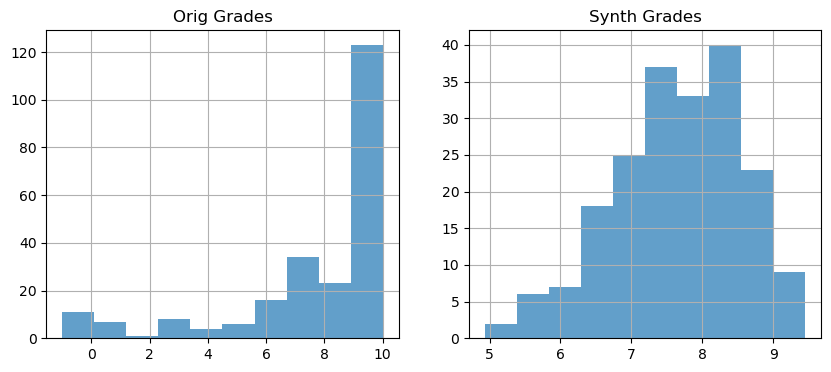

In [7]:
# KS for action probs
from scipy.stats import ks_2samp
orig_actions = log_df['action'].value_counts(normalize=True)
synth_actions = synth_logs_df['action'].value_counts(normalize=True)
ks_stat, ks_p = ks_2samp(orig_actions.values, synth_actions.reindex(orig_actions.index, fill_value=0).values)
print(f"Action KS p: {ks_p:.4f} (>0.05: giống)")

# Corr synthetic
synth_corr = synth_df['actions'].corr(synth_df['finalgrade'])
print(f"Synth corr: {synth_corr:.3f} (gần 0.75)")

# Silhouette
print(f"Synth sil: {sil_synth:.3f}")

synth_df.to_csv('synthetic_features.csv', index=False)


# Plot so sánh grades
fig, ax = plt.subplots(1, 2, figsize=(10,4))
grades_df['finalgrade'].hist(ax=ax[0], alpha=0.7, label='Orig')
synth_grades_df['finalgrade'].hist(ax=ax[1], alpha=0.7, label='Synth')
ax[0].set_title('Orig Grades')
ax[1].set_title('Synth Grades')
plt.show()